In [1]:
!pip install transformers datasets torch wordcloud matplotlib nltk

In [2]:
from datasets import load_dataset
import pandas as pd

# Load a small slice (1%) just for demonstration/speed.
# For final project, use split='train[:10%]' or more if you have time.
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1%]")

print(f"Loaded {len(dataset)} samples for training.")
print("Sample Article:\n", dataset[0]['article'][:200])
print("Sample Summary:\n", dataset[0]['highlights'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Loaded 2871 samples for training.
Sample Article:
 LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on 
Sample Summary:
 Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


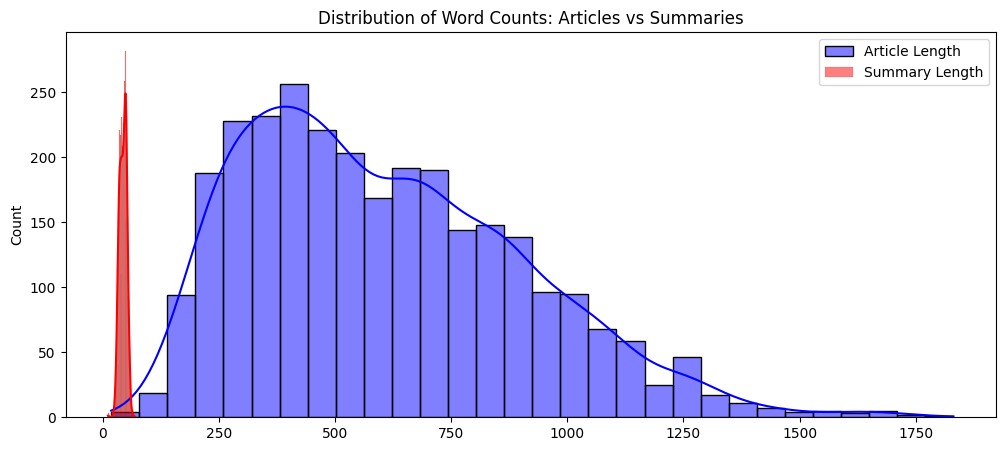

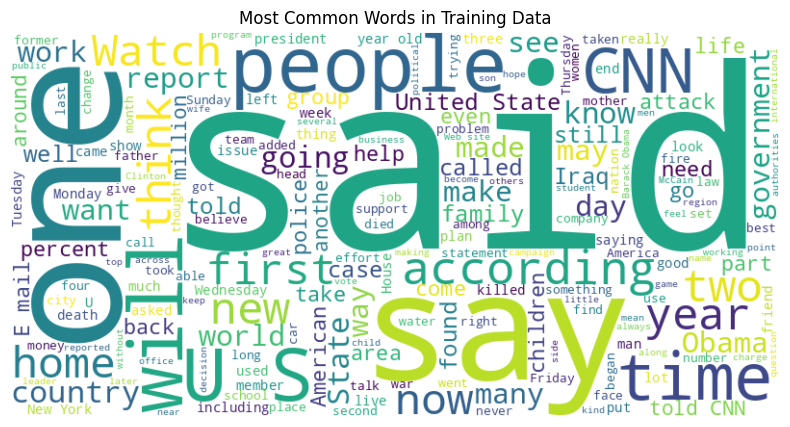

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# 1. TEXT LENGTH DISTRIBUTION
# We need to show that articles are long and summaries are short.
article_lengths = [len(x['article'].split()) for x in dataset]
summary_lengths = [len(x['highlights'].split()) for x in dataset]

plt.figure(figsize=(12, 5))
sns.histplot(article_lengths, color="blue", label="Article Length", kde=True)
sns.histplot(summary_lengths, color="red", label="Summary Length", kde=True)
plt.legend()
plt.title("Distribution of Word Counts: Articles vs Summaries")
plt.show()

# 2. WORD CLOUD
# Shows the most frequent words in your dataset.
all_text = " ".join([x['article'] for x in dataset])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Training Data")
plt.show()

In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

# 1. Load Model & Tokenizer
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# 2. Preprocess Data
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenize targets (summaries)
    labels = tokenizer(examples["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# 3. Define Training Arguments
args = Seq2SeqTrainingArguments(
    output_dir="my_fine_tuned_model",
    eval_strategy="epoch",        # <--- CHANGED THIS LINE (was evaluation_strategy)
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 4. Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets.train_test_split(test_size=0.1)["train"],
    eval_dataset=tokenized_datasets.train_test_split(test_size=0.1)["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# 5. TRAIN!
print("Starting Training...")
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2809634614.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting Training...


Epoch,Training Loss,Validation Loss
1,2.084300,1.842429


TrainOutput(global_step=646, training_loss=2.0813164961965462, metrics={'train_runtime': 207.0278, 'train_samples_per_second': 12.477, 'train_steps_per_second': 3.12, 'total_flos': 672703207243776.0, 'train_loss': 2.0813164961965462, 'epoch': 1.0})

In [8]:
trainer.save_model("my_final_summarizer")
tokenizer.save_pretrained("my_final_summarizer")

# Zip it to download
!zip -r my_model.zip my_final_summarizer
from google.colab import files
files.download("my_model.zip")

  adding: my_final_summarizer/ (stored 0%)
  adding: my_final_summarizer/training_args.bin (deflated 53%)
  adding: my_final_summarizer/model.safetensors (deflated 11%)
  adding: my_final_summarizer/spiece.model (deflated 48%)
  adding: my_final_summarizer/generation_config.json (deflated 27%)
  adding: my_final_summarizer/special_tokens_map.json (deflated 85%)
  adding: my_final_summarizer/tokenizer.json (deflated 74%)
  adding: my_final_summarizer/tokenizer_config.json (deflated 95%)
  adding: my_final_summarizer/config.json (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>